<a href="https://colab.research.google.com/github/nevilj007/Kailasa-capital/blob/main/Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SMA 5-12 + Wavelet (15-min): Uses wavelet transform to smooth noise; trades based on SMA crossover.


In [1]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.8 MB/s eta 0:00:00


banknifty

<ipython-input-2-76b97932e808>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15min['Smoothed_Close'] = wavelet_smooth(df_15min['Close'])
<ipython-input-2-76b97932e808>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15min['Short_SMA'] = df_15min['Smoothed_Close'].rolling(window=short_window).mean()
<ipython-input-2-76b97932e808>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 


--- 📊 Strategy Performance Metrics ---
📈 Final Capital: ₹5,377,327.43
💰 Total Return: 168.87%
🚀 CAGR: 22.73%
📉 Max Drawdown: -5.70%
🕒 Max Drawdown Duration: 4288 bars
📊 Sharpe Ratio: 1.10
📉 Calmar Ratio: 3.99
✅ Win Rate: 50.17%
📊 Number of Trades: 5469
📆 MoM Consistency: 56.45%


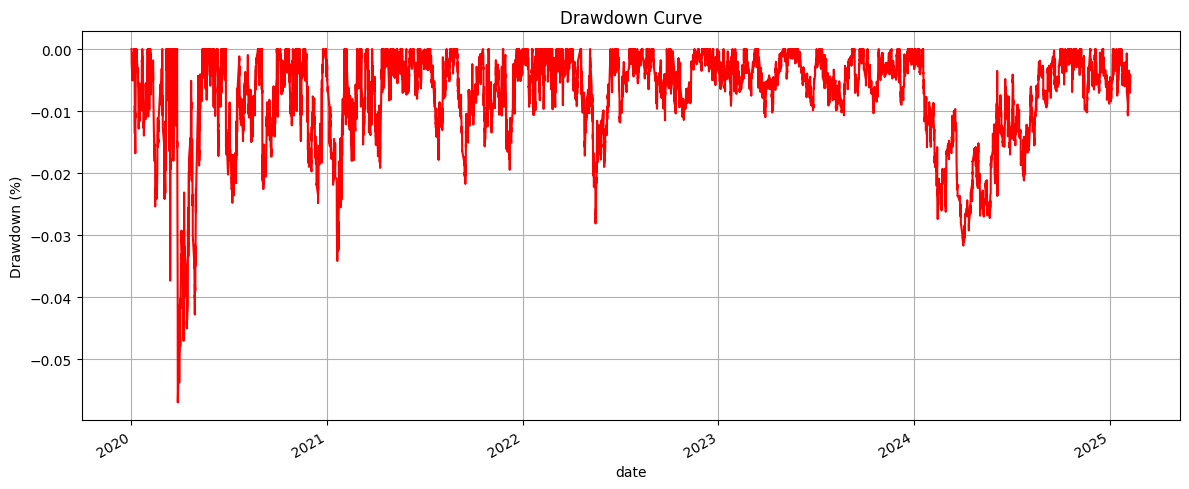

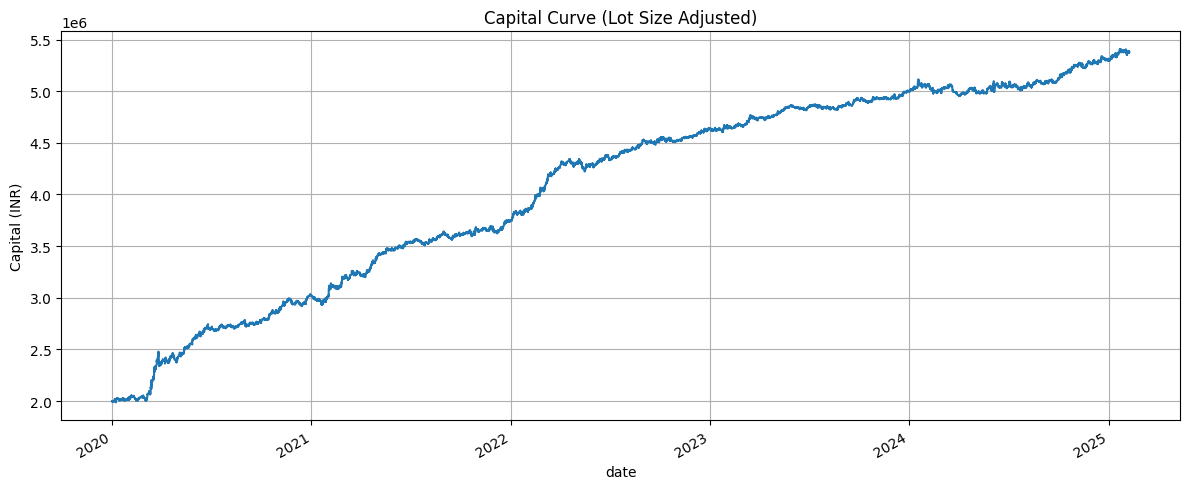

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt  # PyWavelets library for Wavelet Transform

# --- Load and preprocess ---
df = pd.read_csv('/content/NIFTY BANK_minute_data.csv', index_col='date', parse_dates=True)
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

# --- Resample to 15-minute ---
df_15min = df.resample('15min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()
df_15min = df_15min[df_15min.index >= '2020-01-01']

# --- Wavelet Smoothing ---
def wavelet_smooth(signal, wavelet='db4', level=1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
    smoothed_signal = pywt.waverec(coeffs, wavelet)
    return smoothed_signal[:len(signal)]

df_15min['Smoothed_Close'] = wavelet_smooth(df_15min['Close'])

# --- Moving Averages ---
short_window = 5
long_window = 12
df_15min['Short_SMA'] = df_15min['Smoothed_Close'].rolling(window=short_window).mean()
df_15min['Long_SMA'] = df_15min['Smoothed_Close'].rolling(window=long_window).mean()

# --- Signals ---
df_15min['Signal'] = 0
df_15min.loc[df_15min['Short_SMA'] > df_15min['Long_SMA'], 'Signal'] = 1
df_15min.loc[df_15min['Short_SMA'] < df_15min['Long_SMA'], 'Signal'] = -1
df_15min['Position'] = df_15min['Signal'].shift(1)

# --- Lot Size and Capital Calculation ---
# --- Lot Size and Capital Calculation with Slippage & Transaction Cost ---
lot_size = 30
initial_capital = 2_000_000
transaction_cost = 0.01 / 100  # 0.01%
slippage = 0.001 / 100         # 0.001%
total_cost = transaction_cost + slippage

capital = [initial_capital]
units_held = 0

for i in range(1, len(df_15min)):
    price = df_15min['Close'].iloc[i]
    position = df_15min['Position'].iloc[i]

    # Only update position when it changes
    if df_15min['Position'].iloc[i] != df_15min['Position'].iloc[i - 1]:
        units_held = position * lot_size

        # Cost only when trade happens (entry or exit)
        trade_value = abs(lot_size * price)
        cost = trade_value * total_cost
    else:
        cost = 0

    prev_price = df_15min['Close'].iloc[i - 1]
    pnl = units_held * (price - prev_price)

    capital.append(capital[-1] + pnl - cost)


# --- Performance Metrics ---
# --- Performance Metrics ---
# Convert the capital list to a pandas Series before using .iloc
capital = pd.Series(capital, index=df_15min.index)
final_capital = capital.iloc[-1]
total_return = (final_capital / initial_capital - 1) * 100
#... rest of your code ...
trading_days_per_year = 252 * 6.5 * 4
years = len(df_15min) / trading_days_per_year
cagr = ((final_capital / initial_capital) ** (1 / years) - 1) * 100

running_max = capital.cummax()
drawdown = (capital / running_max) - 1
max_drawdown = drawdown.min() * 100

drawdown_periods = (drawdown < 0).astype(int)
drawdown_groups = (drawdown_periods.diff() != 0).cumsum()
drawdown_durations = drawdown_periods.groupby(drawdown_groups).cumsum()
max_drawdown_duration = drawdown_durations.max()

df_15min['Returns'] = df_15min['Close'].pct_change()
df_15min['Strategy_Return'] = df_15min['Position'].shift(1) * df_15min['Returns']
risk_free_rate = 0.02
excess_returns = df_15min['Strategy_Return'] - (risk_free_rate / trading_days_per_year)
sharpe_ratio = np.sqrt(trading_days_per_year) * excess_returns.mean() / excess_returns.std()
calmar_ratio = cagr / abs(max_drawdown)

trade_returns = df_15min['Strategy_Return'][df_15min['Signal'] != 0]
win_rate = (trade_returns > 0).mean() * 100

df_15min['Trade_Change'] = df_15min['Position'].diff().fillna(0).abs()
num_trades = int(df_15min['Trade_Change'].sum())
monthly_returns = df_15min['Strategy_Return'].resample('M').sum()
mom_consistency = (monthly_returns > 0).mean() * 100

# --- Results ---
print("\n--- 📊 Strategy Performance Metrics ---")
print(f"📈 Final Capital: ₹{final_capital:,.2f}")
print(f"💰 Total Return: {total_return:.2f}%")
print(f"🚀 CAGR: {cagr:.2f}%")
print(f"📉 Max Drawdown: {max_drawdown:.2f}%")
print(f"🕒 Max Drawdown Duration: {max_drawdown_duration} bars")
print(f"📊 Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"📉 Calmar Ratio: {calmar_ratio:.2f}")
print(f"✅ Win Rate: {win_rate:.2f}%")
print(f"📊 Number of Trades: {num_trades}")
print(f"📆 MoM Consistency: {mom_consistency:.2f}%")

# --- Plots ---
drawdown.plot(title='Drawdown Curve', figsize=(12, 5), color='red', grid=True)
plt.ylabel('Drawdown (%)')
plt.tight_layout()
plt.show()

capital.plot(title='Capital Curve (Lot Size Adjusted)', figsize=(12, 5), grid=True)
plt.ylabel('Capital (INR)')
plt.tight_layout()
plt.show()



nifty50

<ipython-input-3-0ab444115303>:105: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df_15min['Strategy_Return'].resample('M').sum()



--- 📊 Strategy Performance Metrics ---
📈 Final Capital: ₹4,747,424.67
💰 Total Return: 137.37%
🚀 CAGR: 19.60%
📉 Max Drawdown: -4.52%
🕒 Max Drawdown Duration: 3948 bars
📊 Sharpe Ratio: 1.14
📉 Calmar Ratio: 4.34
✅ Win Rate: 50.69%
📊 Number of Trades: 5217
📆 MoM Consistency: 62.90%


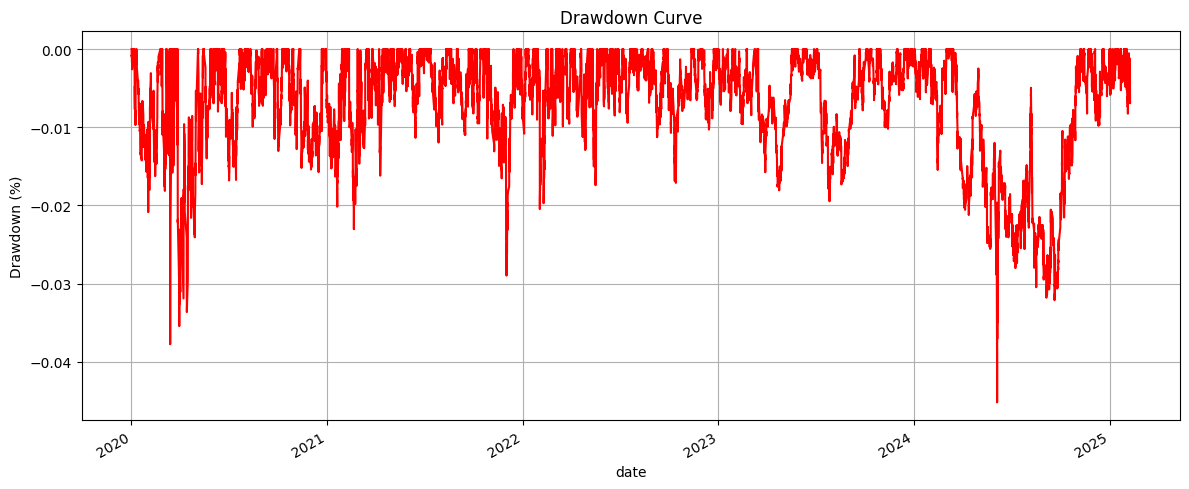

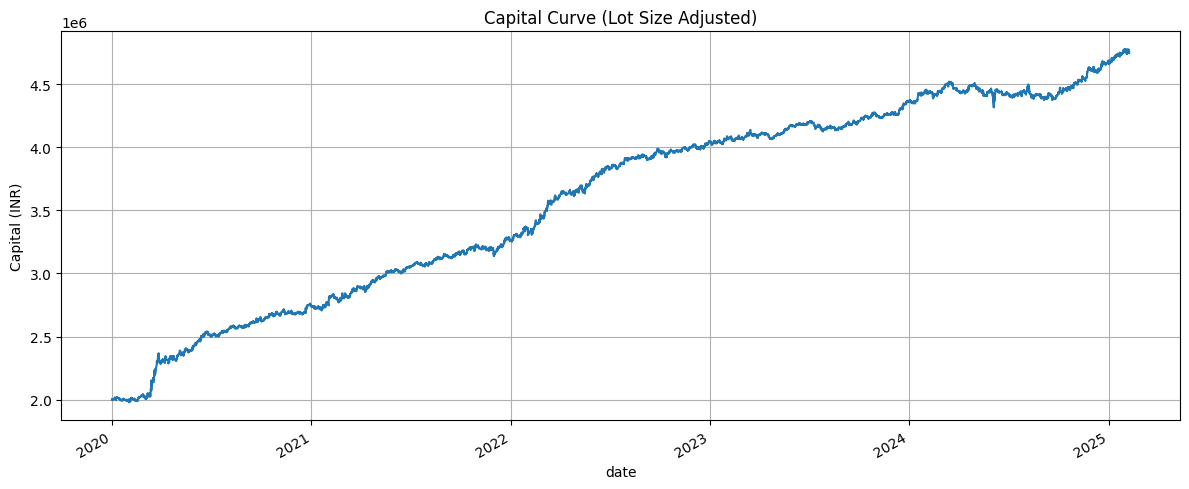

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt  # PyWavelets library for Wavelet Transform

# --- Load and preprocess ---
df = pd.read_csv('/content/NIFTY 50_minute_data.csv', index_col='date', parse_dates=True)
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

# --- Resample to 15-minute ---
df_15min = df.resample('15min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()
df_15min = df_15min[df_15min.index >= '2020-01-01']

# --- Wavelet Smoothing ---
def wavelet_smooth(signal, wavelet='db4', level=1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
    smoothed_signal = pywt.waverec(coeffs, wavelet)
    return smoothed_signal[:len(signal)]

df_15min['Smoothed_Close'] = wavelet_smooth(df_15min['Close'])

# --- Moving Averages ---
short_window = 5
long_window = 12
df_15min['Short_SMA'] = df_15min['Smoothed_Close'].rolling(window=short_window).mean()
df_15min['Long_SMA'] = df_15min['Smoothed_Close'].rolling(window=long_window).mean()

# --- Signals ---
df_15min['Signal'] = 0
df_15min.loc[df_15min['Short_SMA'] > df_15min['Long_SMA'], 'Signal'] = 1
df_15min.loc[df_15min['Short_SMA'] < df_15min['Long_SMA'], 'Signal'] = -1
df_15min['Position'] = df_15min['Signal'].shift(1)

# --- Lot Size and Capital Calculation ---
# --- Lot Size and Capital Calculation with Slippage & Transaction Cost ---
lot_size = 75
initial_capital = 2_000_000
transaction_cost = 0.01 / 100  # 0.01%
slippage = 0.001 / 100         # 0.001%
total_cost = transaction_cost + slippage

capital = [initial_capital]
units_held = 0

for i in range(1, len(df_15min)):
    price = df_15min['Close'].iloc[i]
    position = df_15min['Position'].iloc[i]

    # Only update position when it changes
    if df_15min['Position'].iloc[i] != df_15min['Position'].iloc[i - 1]:
        units_held = position * lot_size

        # Cost only when trade happens (entry or exit)
        trade_value = abs(lot_size * price)
        cost = trade_value * total_cost
    else:
        cost = 0

    prev_price = df_15min['Close'].iloc[i - 1]
    pnl = units_held * (price - prev_price)

    capital.append(capital[-1] + pnl - cost)


# --- Performance Metrics ---
# --- Performance Metrics ---
# Convert the capital list to a pandas Series before using .iloc
capital = pd.Series(capital, index=df_15min.index)
final_capital = capital.iloc[-1]
total_return = (final_capital / initial_capital - 1) * 100
#... rest of your code ...
trading_days_per_year = 252 * 6.5 * 4
years = len(df_15min) / trading_days_per_year
cagr = ((final_capital / initial_capital) ** (1 / years) - 1) * 100

running_max = capital.cummax()
drawdown = (capital / running_max) - 1
max_drawdown = drawdown.min() * 100

drawdown_periods = (drawdown < 0).astype(int)
drawdown_groups = (drawdown_periods.diff() != 0).cumsum()
drawdown_durations = drawdown_periods.groupby(drawdown_groups).cumsum()
max_drawdown_duration = drawdown_durations.max()

df_15min['Returns'] = df_15min['Close'].pct_change()
df_15min['Strategy_Return'] = df_15min['Position'].shift(1) * df_15min['Returns']
risk_free_rate = 0.02
excess_returns = df_15min['Strategy_Return'] - (risk_free_rate / trading_days_per_year)
sharpe_ratio = np.sqrt(trading_days_per_year) * excess_returns.mean() / excess_returns.std()
calmar_ratio = cagr / abs(max_drawdown)

trade_returns = df_15min['Strategy_Return'][df_15min['Signal'] != 0]
win_rate = (trade_returns > 0).mean() * 100

df_15min['Trade_Change'] = df_15min['Position'].diff().fillna(0).abs()
num_trades = int(df_15min['Trade_Change'].sum())
monthly_returns = df_15min['Strategy_Return'].resample('M').sum()
mom_consistency = (monthly_returns > 0).mean() * 100

# --- Results ---
print("\n--- 📊 Strategy Performance Metrics ---")
print(f"📈 Final Capital: ₹{final_capital:,.2f}")
print(f"💰 Total Return: {total_return:.2f}%")
print(f"🚀 CAGR: {cagr:.2f}%")
print(f"📉 Max Drawdown: {max_drawdown:.2f}%")
print(f"🕒 Max Drawdown Duration: {max_drawdown_duration} bars")
print(f"📊 Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"📉 Calmar Ratio: {calmar_ratio:.2f}")
print(f"✅ Win Rate: {win_rate:.2f}%")
print(f"📊 Number of Trades: {num_trades}")
print(f"📆 MoM Consistency: {mom_consistency:.2f}%")

# --- Plots ---
drawdown.plot(title='Drawdown Curve', figsize=(12, 5), color='red', grid=True)
plt.ylabel('Drawdown (%)')
plt.tight_layout()
plt.show()

capital.plot(title='Capital Curve (Lot Size Adjusted)', figsize=(12, 5), grid=True)
plt.ylabel('Capital (INR)')
plt.tight_layout()
plt.show()



 RSI with mean crossover


nifty50

<ipython-input-6-8ac0346813b5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['21_EMA'] = df['Close'].ewm(span=15, adjust=False).mean()
<ipython-input-6-8ac0346813b5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = 100 - (100 / (1 + rs))
<ipython-input-6-8ac0346813b5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Total Return: ₹1,676,734.76
CAGR: 12.83%
Sharpe Ratio: 0.82
Calmar Ratio: 0.52
Max Drawdown: 24.75%
Max Drawdown Duration: 227 days
Win Rate: 29.21%
Trade Frequency: 40.05 trades/year


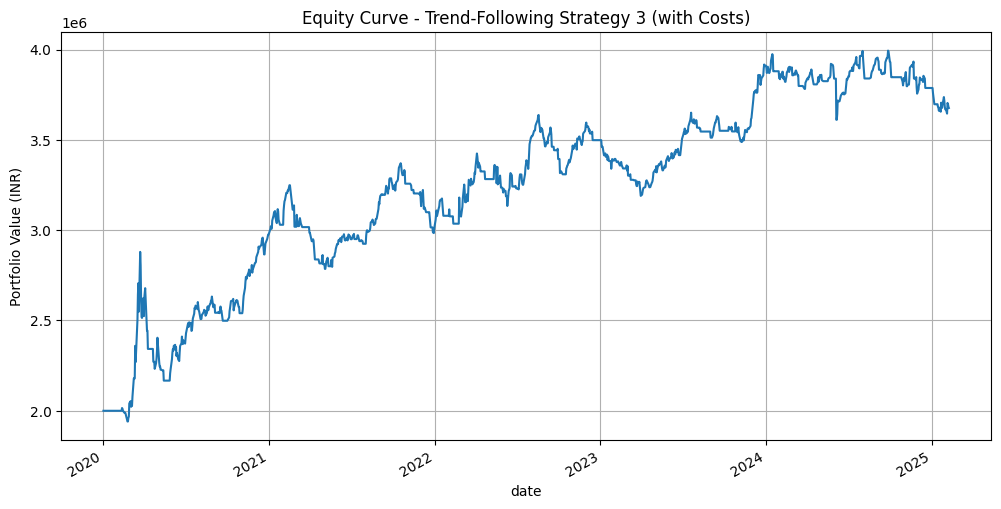

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('/content/NIFTY 50_daily_data.csv', index_col='date', parse_dates=True)
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df = df[df.index >= '2020-01-01']

# Calculate indicators
df['21_EMA'] = df['Close'].ewm(span=15, adjust=False).mean()
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(30).mean()
avg_loss = loss.rolling(30).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Generate signals
df['Signal'] = 0
df.loc[(df['Close'] > df['21_EMA']) & (df['RSI'] > 40), 'Signal'] = 1  # Long signal
df.loc[(df['Close'] < df['21_EMA']) & (df['RSI'] < 40), 'Signal'] = -1  # Short signal

# Position tracking
df['Position'] = df['Signal'].shift(1)  # Avoid lookahead bias

# Calculate returns
df['Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Position'] * df['Return']

# Portfolio simulation with transaction cost and slippage
#df['Units'] = 75
df['Equity'] = 0.0
initial_capital = 2_000_000
lot_size = 75
total_cost_rate = (0.01 + 0.001) / 100  # 0.011%

equity = initial_capital
prev_position = 0
equity_curve = []

for i in range(1, len(df)):
    price = df['Close'].iloc[i]
    ret = df['Strategy_Return'].iloc[i]
    position = df['Position'].iloc[i]

    # Apply cost if position changes (i.e., a new trade occurs)
    if position != prev_position:
        trade_cost = lot_size * price * total_cost_rate
    else:
        trade_cost = 0

    equity *= (1 + ret)
    equity -= trade_cost
    equity_curve.append(equity)

    prev_position = position

# Pad the equity curve for alignment
df = df.iloc[1:]
df['Equity'] = equity_curve

# Performance metrics
total_return = df['Equity'].iloc[-1] - initial_capital
cagr = (df['Equity'].iloc[-1] / initial_capital) ** (252 / len(df)) - 1
sharpe_ratio = df['Strategy_Return'].mean() / df['Strategy_Return'].std() * np.sqrt(252)

# Max Drawdown
df['Peak'] = df['Equity'].cummax()
df['Drawdown'] = (df['Peak'] - df['Equity']) / df['Peak']
max_drawdown = df['Drawdown'].max()

# Max Drawdown Duration
drawdown_duration = (df['Drawdown'] > 0).astype(int).groupby((df['Drawdown'] == 0).cumsum()).cumsum()
max_drawdown_duration = drawdown_duration.max()

# Calmar Ratio
calmar_ratio = cagr / max_drawdown if max_drawdown > 0 else np.inf

# Trade Frequency and Win Rate
trades = df[df['Position'] != df['Position'].shift(1)]
trade_returns = trades['Strategy_Return'].dropna()
win_trades = trade_returns[trade_returns > 0]
win_rate = len(win_trades) / len(trade_returns) if len(trade_returns) > 0 else 0
trade_frequency = len(trades) / len(df)

# Output metrics
print(f"Total Return: ₹{total_return:,.2f}")
print(f"CAGR: {cagr * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"Max Drawdown Duration: {max_drawdown_duration} days")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Trade Frequency: {trade_frequency * 252:.2f} trades/year")

# Plot equity curve
df['Equity'].plot(figsize=(12, 6), title='Equity Curve - Trend-Following Strategy 3 (with Costs)')
plt.ylabel('Portfolio Value (INR)')
plt.grid(True)
plt.show()


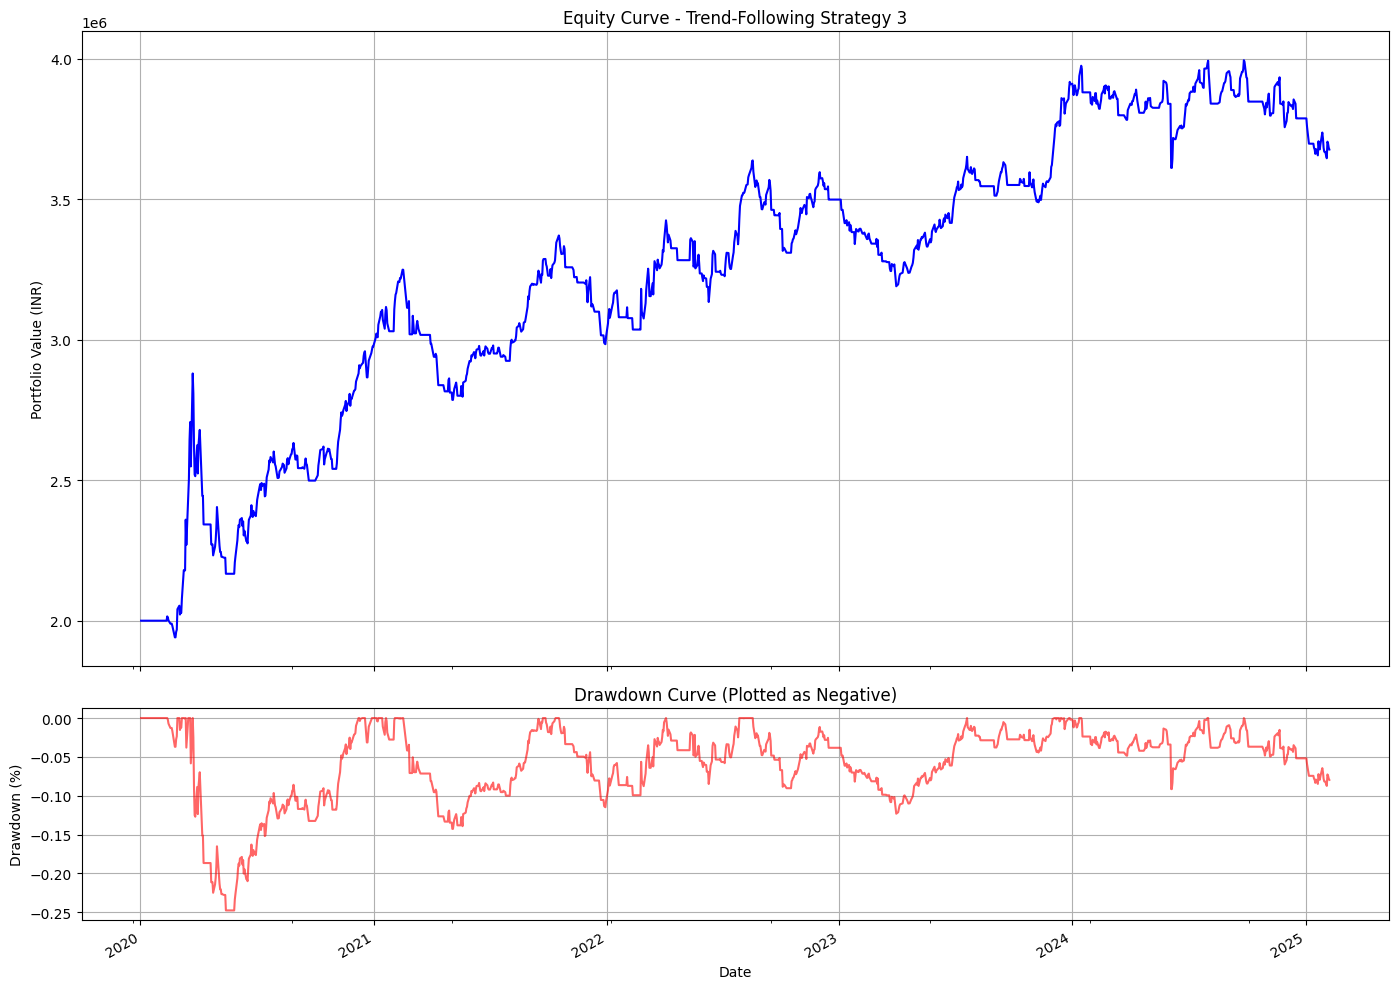

In [7]:
# --- Plot Equity Curve and Negative Drawdown Curve ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Equity Curve
df['Equity'].plot(ax=ax1, title='Equity Curve - Trend-Following Strategy 3', color='blue')
ax1.set_ylabel('Portfolio Value (INR)')
ax1.grid(True)

# Negative Drawdown Curve
(df['Drawdown'] * -1).plot(ax=ax2, color='red', alpha=0.6)
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Date')
ax2.set_title('Drawdown Curve (Plotted as Negative)')
ax2.grid(True)

plt.tight_layout()
plt.show()


banknifty


Total Return: ₹1,361,684.19
CAGR: 10.84%
Sharpe Ratio: 0.59
Calmar Ratio: 0.35
Max Drawdown: 31.35%
Max Drawdown Duration: 989 days
Win Rate: 31.36%
Trade Frequency: 43.62 trades/year


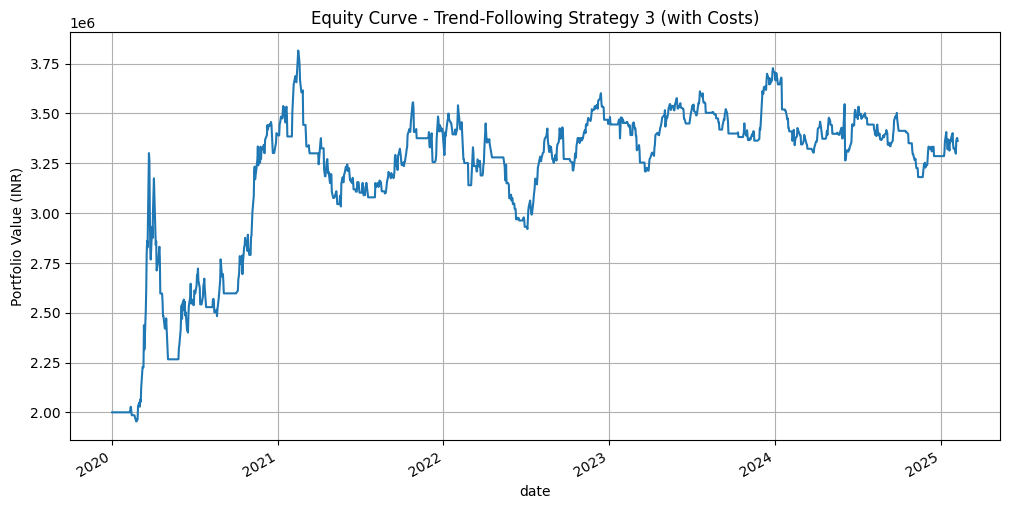

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('/content/NIFTY BANK_daily_data.csv', index_col='date', parse_dates=True)
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df = df[df.index >= '2020-01-01']

# Calculate indicators
df['21_EMA'] = df['Close'].ewm(span=15, adjust=False).mean()
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(30).mean()
avg_loss = loss.rolling(30).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Generate signals
df['Signal'] = 0
df.loc[(df['Close'] > df['21_EMA']) & (df['RSI'] > 40), 'Signal'] = 1  # Long signal
df.loc[(df['Close'] < df['21_EMA']) & (df['RSI'] < 40), 'Signal'] = -1  # Short signal

# Position tracking
df['Position'] = df['Signal'].shift(1)  # Avoid lookahead bias

# Calculate returns
df['Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Position'] * df['Return']

# Portfolio simulation with transaction cost and slippage
#df['Units'] = 75
df['Equity'] = 0.0
initial_capital = 2_000_000
lot_size = 30
total_cost_rate = (0.01 + 0.001) / 100  # 0.011%

equity = initial_capital
prev_position = 0
equity_curve = []

for i in range(1, len(df)):
    price = df['Close'].iloc[i]
    ret = df['Strategy_Return'].iloc[i]
    position = df['Position'].iloc[i]

    # Apply cost if position changes (i.e., a new trade occurs)
    if position != prev_position:
        trade_cost = lot_size * price * total_cost_rate
    else:
        trade_cost = 0

    equity *= (1 + ret)
    equity -= trade_cost
    equity_curve.append(equity)

    prev_position = position

# Pad the equity curve for alignment
df = df.iloc[1:]
df['Equity'] = equity_curve

# Performance metrics
total_return = df['Equity'].iloc[-1] - initial_capital
cagr = (df['Equity'].iloc[-1] / initial_capital) ** (252 / len(df)) - 1
sharpe_ratio = df['Strategy_Return'].mean() / df['Strategy_Return'].std() * np.sqrt(252)

# Max Drawdown
df['Peak'] = df['Equity'].cummax()
df['Drawdown'] = (df['Peak'] - df['Equity']) / df['Peak']
max_drawdown = df['Drawdown'].max()

# Max Drawdown Duration
drawdown_duration = (df['Drawdown'] > 0).astype(int).groupby((df['Drawdown'] == 0).cumsum()).cumsum()
max_drawdown_duration = drawdown_duration.max()

# Calmar Ratio
calmar_ratio = cagr / max_drawdown if max_drawdown > 0 else np.inf

# Trade Frequency and Win Rate
trades = df[df['Position'] != df['Position'].shift(1)]
trade_returns = trades['Strategy_Return'].dropna()
win_trades = trade_returns[trade_returns > 0]
win_rate = len(win_trades) / len(trade_returns) if len(trade_returns) > 0 else 0
trade_frequency = len(trades) / len(df)

# Output metrics
print(f"Total Return: ₹{total_return:,.2f}")
print(f"CAGR: {cagr * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"Max Drawdown Duration: {max_drawdown_duration} days")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Trade Frequency: {trade_frequency * 252:.2f} trades/year")

# Plot equity curve
df['Equity'].plot(figsize=(12, 6), title='Equity Curve - Trend-Following Strategy 3 (with Costs)')
plt.ylabel('Portfolio Value (INR)')
plt.grid(True)
plt.show()


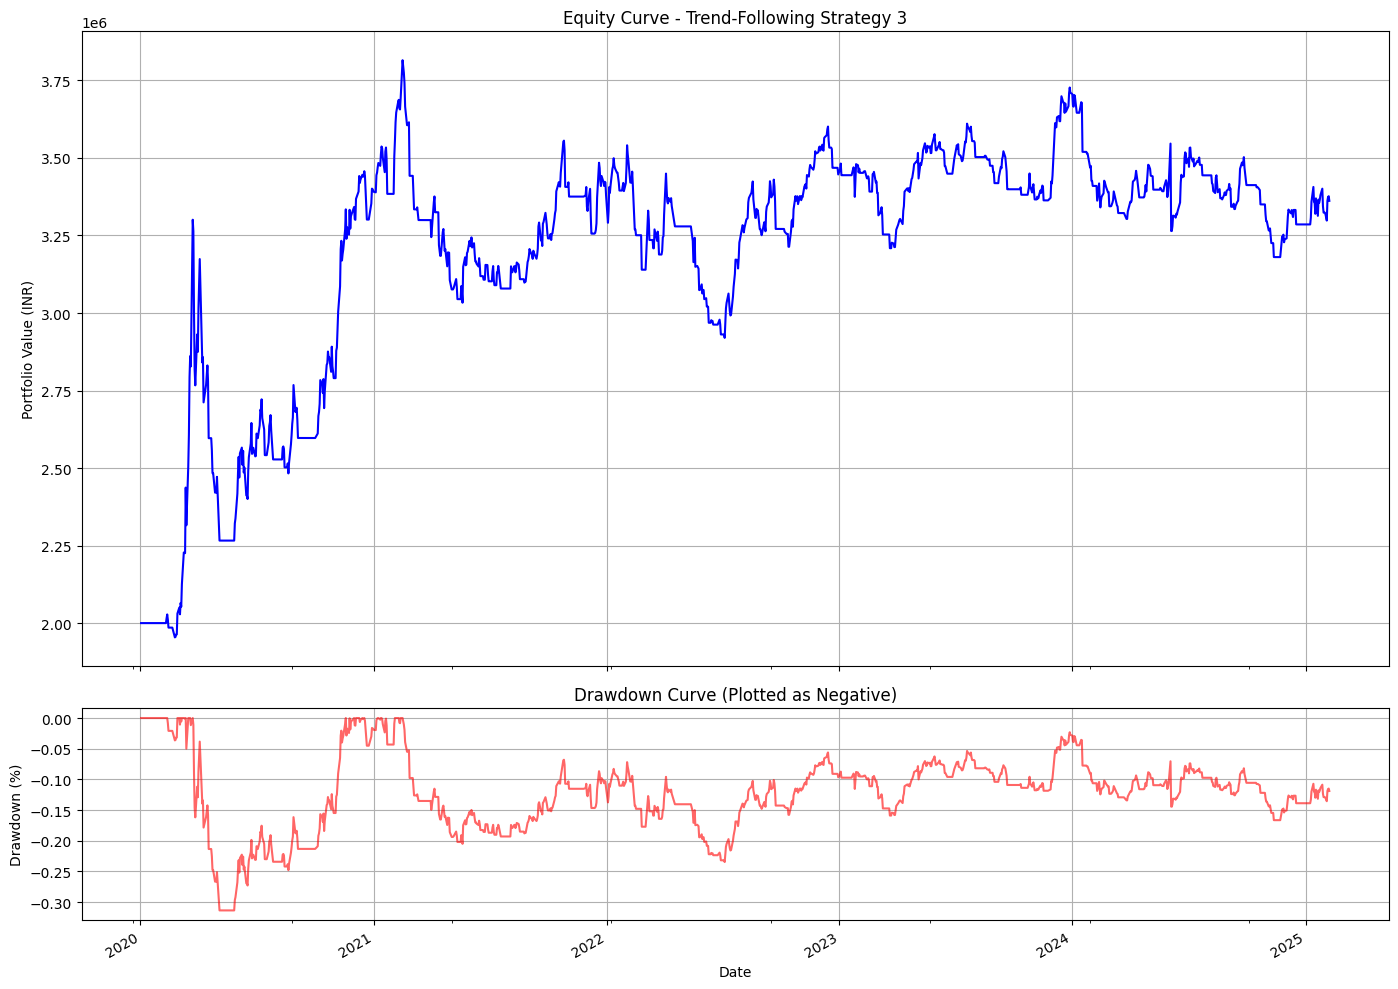

In [9]:
# --- Plot Equity Curve and Negative Drawdown Curve ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Equity Curve
df['Equity'].plot(ax=ax1, title='Equity Curve - Trend-Following Strategy 3', color='blue')
ax1.set_ylabel('Portfolio Value (INR)')
ax1.grid(True)

# Negative Drawdown Curve
(df['Drawdown'] * -1).plot(ax=ax2, color='red', alpha=0.6)
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Date')
ax2.set_title('Drawdown Curve (Plotted as Negative)')
ax2.grid(True)

plt.tight_layout()
plt.show()


EMA 20-50 (1-hour): Captures momentum trends through EMA crossover.



=== Final Strategy Performance ===
CAGR                        :  22.81%
Sharpe Ratio                :  1.50
Calmar Ratio                :  5.27
Max Drawdown                : -4.33%
Max Drawdown Duration       : 1139 bars
Filtered Max DD Duration    : 538 bars (DD < -2%)
Monthly Consistency         :  70.97%
Final Strategy Return       :  185.61%
Final Market Return         :  93.13%
Number of Trades            : 521
Winning Trades              : 260
Win Rate                    :  49.90%
Average Trade Return        :  0.2051%
Profit Factor               :  2.33
Expectancy                  :  0.0021
Average Holding Period      : 1 bar(s)
Annualized Volatility       :  0.0850
Sortino Ratio               :  2.38


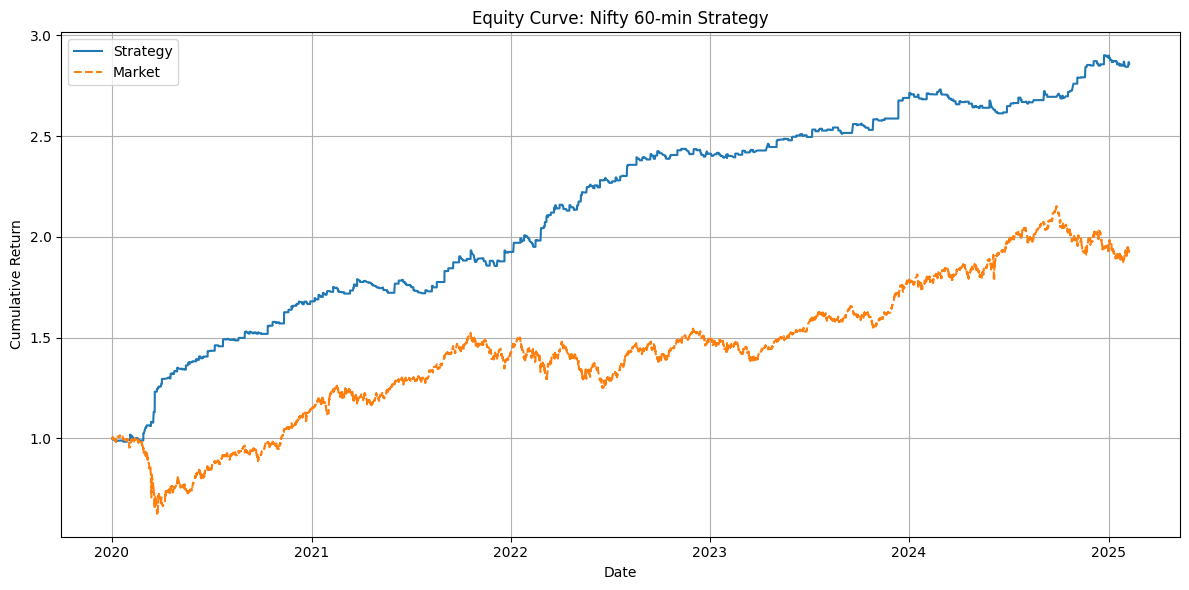

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ───── PARAMETERS ─────────────────────────────────────────────────────────────
initial_capital      = 1_000_000
margin_pct           = 1
lot_size             = 75
transaction_cost_pct = 0.001
slippage_pct         = 0.0001
trail_pct            = 0.005
rf_rate              = 0.07
trading_hours_per_year = 252 * 6.5

# ───── LOAD DATA ───────────────────────────────────────────────────────────────
df = pd.read_csv("/content/nifty_60min.csv", parse_dates=['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# ───── INDICATORS ──────────────────────────────────────────────────────────────
df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ───── STATE VARIABLES ─────────────────────────────────────────────────────────
capital = initial_capital
df['strategy_returns'] = 0.0
position = None
entry_price = sl_price = 0.0
trade_count = 0
winning_trades = 0
lots_traded = 0
trade_returns = []

# ───── HELPERS ─────────────────────────────────────────────────────────────────
def adjust_price(price):
    slippage = price * slippage_pct
    cost = price * transaction_cost_pct
    return price + slippage, cost

# ───── STRATEGY LOOP ───────────────────────────────────────────────────────────
for i in range(2, len(df)):
    bar = df.iloc[i]
    signal_bar = df.iloc[i-1]
    prev_bar = df.iloc[i-2]

    entry_open = bar['open']
    adj_price, cost = adjust_price(entry_open)
    notional_per_lot = adj_price * lot_size
    margin_per_lot = notional_per_lot * margin_pct
    max_lots_affordable = int(capital // margin_per_lot)
    if max_lots_affordable < 1:
        continue

    # ENTRY
    if position is None:
        if (signal_bar.ema_20 > signal_bar.ema_50
            and prev_bar['close'] < prev_bar['open']
            and signal_bar['high'] > prev_bar['high']):
            position = 'long'
            entry_price = adj_price
            sl_price = entry_price * (1 - trail_pct)
            lots_traded = max_lots_affordable
            trade_count += 1

        elif (signal_bar.ema_20 < signal_bar.ema_50
              and prev_bar['close'] > prev_bar['open']
              and signal_bar['low'] < prev_bar['low']):
            position = 'short'
            entry_price = adj_price
            sl_price = entry_price * (1 + trail_pct)
            lots_traded = max_lots_affordable
            trade_count += 1

    # EXIT
    else:
        adj_now, _ = adjust_price(bar['close'])

        if position == 'long':
            sl_price = max(sl_price, adj_now * (1 - trail_pct))
            if adj_now < sl_price:
                pnl = (sl_price - entry_price - cost) * lots_traded * lot_size
                ret = pnl / capital
                df.iloc[i, df.columns.get_loc('strategy_returns')] = ret
                trade_returns.append(ret)
                capital += pnl
                if sl_price > entry_price:
                    winning_trades += 1
                position = None

        elif position == 'short':
            sl_price = min(sl_price, adj_now * (1 + trail_pct))
            if adj_now > sl_price:
                pnl = (entry_price - sl_price - cost) * lots_traded * lot_size
                ret = pnl / capital
                df.iloc[i, df.columns.get_loc('strategy_returns')] = ret
                trade_returns.append(ret)
                capital += pnl
                if entry_price > sl_price:
                    winning_trades += 1
                position = None

# ───── PERFORMANCE ─────────────────────────────────────────────────────────────
returns = df['strategy_returns']
cumulative = (1 + returns).cumprod()
market_returns = df['close'].pct_change().fillna(0)
cum_market = (1 + market_returns).cumprod()
years = (df.index[-1] - df.index[0]).days / 365

CAGR = cumulative.iloc[-1]**(1/years) - 1
drawdown = cumulative / cumulative.cummax() - 1
Max_Drawdown = drawdown.min()
Sharpe = ((returns.mean()*trading_hours_per_year - rf_rate) /
          (returns.std()*np.sqrt(trading_hours_per_year))
          if returns.std()>0 else np.nan)
Calmar = CAGR / abs(Max_Drawdown) if Max_Drawdown < 0 else np.nan

# ───── EXTENDED METRICS ────────────────────────────────────────────────────────
trade_returns = np.array(trade_returns)
Average_Trade_Return = np.mean(trade_returns)
Gross_Profit = np.sum(trade_returns[trade_returns > 0])
Gross_Loss = -np.sum(trade_returns[trade_returns < 0])
Profit_Factor = Gross_Profit / Gross_Loss if Gross_Loss != 0 else np.nan
Expectancy = Average_Trade_Return
Volatility = returns.std() * np.sqrt(trading_hours_per_year)
downside_returns = returns[returns < 0]
Sortino = ((returns.mean()*trading_hours_per_year - rf_rate) /
           (downside_returns.std()*np.sqrt(trading_hours_per_year))
           if downside_returns.std()>0 else np.nan)
Avg_Holding_Period = 1  # can be customized if trade durations are tracked

# ───── DRAWDOWN DURATIONS ──────────────────────────────────────────────────────
dd_flag = drawdown < 0
durations = dd_flag.groupby((dd_flag != dd_flag.shift()).cumsum()).cumsum()
Max_DD_Duration = durations.max()

dd_thresh = -0.02
effective_dd_flag = drawdown < dd_thresh
effective_durations = effective_dd_flag.groupby((effective_dd_flag != effective_dd_flag.shift()).cumsum()).cumsum()
Filtered_Max_Duration = effective_durations.max()

monthly_ret = returns.resample('ME').sum()
Mon_consistency = (monthly_ret > 0).mean()

# ───── PRINT FINAL STRATEGY STATS ──────────────────────────────────────────────
print(f"\n=== Final Strategy Performance ===")
print(f"CAGR                        : {CAGR*100: .2f}%")
print(f"Sharpe Ratio                : {Sharpe: .2f}")
print(f"Calmar Ratio                : {Calmar: .2f}")
print(f"Max Drawdown                : {Max_Drawdown*100: .2f}%")
print(f"Max Drawdown Duration       : {Max_DD_Duration} bars")
print(f"Filtered Max DD Duration    : {Filtered_Max_Duration} bars (DD < -2%)")
print(f"Monthly Consistency         : {Mon_consistency*100: .2f}%")
print(f"Final Strategy Return       : {(cumulative.iloc[-1]-1)*100: .2f}%")
print(f"Final Market Return         : {(cum_market.iloc[-1]-1)*100: .2f}%")
print(f"Number of Trades            : {trade_count}")
print(f"Winning Trades              : {winning_trades}")
print(f"Win Rate                    : {winning_trades/trade_count*100 if trade_count>0 else 0: .2f}%")
print(f"Average Trade Return        : {Average_Trade_Return*100: .4f}%")
print(f"Profit Factor               : {Profit_Factor: .2f}")
print(f"Expectancy                  : {Expectancy: .4f}")
print(f"Average Holding Period      : {Avg_Holding_Period} bar(s)")
print(f"Annualized Volatility       : {Volatility: .4f}")
print(f"Sortino Ratio               : {Sortino: .2f}")

# ───── PLOT EQUITY CURVE ────────────────────────────────────────────────────────
plt.figure(figsize=(12,6))
plt.plot(cumulative, label="Strategy")
plt.plot(cum_market, '--', label="Market")
plt.title("Equity Curve: Nifty 60-min Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


=== Final Strategy Performance ===
CAGR                        :  50.17%
Sharpe Ratio                :  2.45
Calmar Ratio                :  13.73
Max Drawdown                : -3.65%
Max Drawdown Duration       : 731 bars
Filtered Max DD Duration    : 117 bars (DD < -2%)
Monthly Consistency         :  87.10%
Final Strategy Return       :  697.67%
Final Market Return         :  55.89%
Number of Trades            : 653
Winning Trades              : 314
Win Rate                    :  48.09%
Average Trade Return        :  0.3250%
Profit Factor               :  2.49
Expectancy                  :  0.0033
Average Holding Period      : 1 bar(s)
Annualized Volatility       :  0.1314
Sortino Ratio               :  5.04


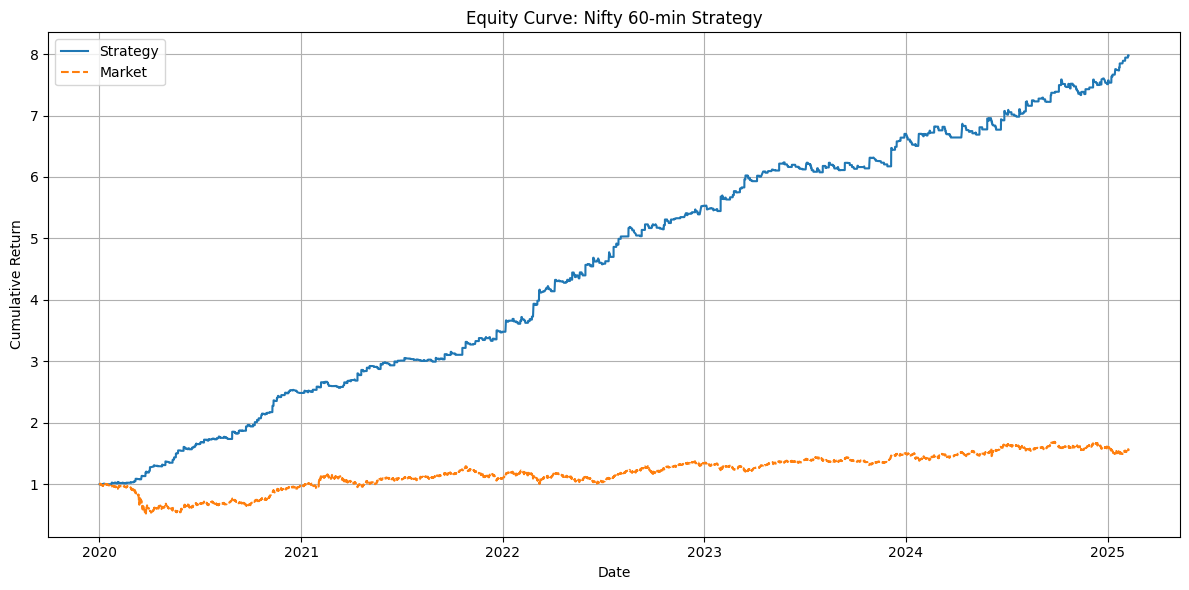

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ───── PARAMETERS ─────────────────────────────────────────────────────────────
initial_capital      = 1_000_000
margin_pct           = 1
lot_size             = 30
transaction_cost_pct = 0.001
slippage_pct         = 0.0001
trail_pct            = 0.005
rf_rate              = 0.07
trading_hours_per_year = 252 * 6.5

# ───── LOAD DATA ───────────────────────────────────────────────────────────────
df = pd.read_csv("/content/banknifty_60min.csv", parse_dates=['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# ───── INDICATORS ──────────────────────────────────────────────────────────────
df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ───── STATE VARIABLES ─────────────────────────────────────────────────────────
capital = initial_capital
df['strategy_returns'] = 0.0
position = None
entry_price = sl_price = 0.0
trade_count = 0
winning_trades = 0
lots_traded = 0
trade_returns = []

# ───── HELPERS ─────────────────────────────────────────────────────────────────
def adjust_price(price):
    slippage = price * slippage_pct
    cost = price * transaction_cost_pct
    return price + slippage, cost

# ───── STRATEGY LOOP ───────────────────────────────────────────────────────────
for i in range(2, len(df)):
    bar = df.iloc[i]
    signal_bar = df.iloc[i-1]
    prev_bar = df.iloc[i-2]

    entry_open = bar['open']
    adj_price, cost = adjust_price(entry_open)
    notional_per_lot = adj_price * lot_size
    margin_per_lot = notional_per_lot * margin_pct
    max_lots_affordable = int(capital // margin_per_lot)
    if max_lots_affordable < 1:
        continue

    # ENTRY
    if position is None:
        if (signal_bar.ema_20 > signal_bar.ema_50
            and prev_bar['close'] < prev_bar['open']
            and signal_bar['high'] > prev_bar['high']):
            position = 'long'
            entry_price = adj_price
            sl_price = entry_price * (1 - trail_pct)
            lots_traded = max_lots_affordable
            trade_count += 1

        elif (signal_bar.ema_20 < signal_bar.ema_50
              and prev_bar['close'] > prev_bar['open']
              and signal_bar['low'] < prev_bar['low']):
            position = 'short'
            entry_price = adj_price
            sl_price = entry_price * (1 + trail_pct)
            lots_traded = max_lots_affordable
            trade_count += 1

    # EXIT
    else:
        adj_now, _ = adjust_price(bar['close'])

        if position == 'long':
            sl_price = max(sl_price, adj_now * (1 - trail_pct))
            if adj_now < sl_price:
                pnl = (sl_price - entry_price - cost) * lots_traded * lot_size
                ret = pnl / capital
                df.iloc[i, df.columns.get_loc('strategy_returns')] = ret
                trade_returns.append(ret)
                capital += pnl
                if sl_price > entry_price:
                    winning_trades += 1
                position = None

        elif position == 'short':
            sl_price = min(sl_price, adj_now * (1 + trail_pct))
            if adj_now > sl_price:
                pnl = (entry_price - sl_price - cost) * lots_traded * lot_size
                ret = pnl / capital
                df.iloc[i, df.columns.get_loc('strategy_returns')] = ret
                trade_returns.append(ret)
                capital += pnl
                if entry_price > sl_price:
                    winning_trades += 1
                position = None

# ───── PERFORMANCE ─────────────────────────────────────────────────────────────
returns = df['strategy_returns']
cumulative = (1 + returns).cumprod()
market_returns = df['close'].pct_change().fillna(0)
cum_market = (1 + market_returns).cumprod()
years = (df.index[-1] - df.index[0]).days / 365

CAGR = cumulative.iloc[-1]**(1/years) - 1
drawdown = cumulative / cumulative.cummax() - 1
Max_Drawdown = drawdown.min()
Sharpe = ((returns.mean()*trading_hours_per_year - rf_rate) /
          (returns.std()*np.sqrt(trading_hours_per_year))
          if returns.std()>0 else np.nan)
Calmar = CAGR / abs(Max_Drawdown) if Max_Drawdown < 0 else np.nan

# ───── EXTENDED METRICS ────────────────────────────────────────────────────────
trade_returns = np.array(trade_returns)
Average_Trade_Return = np.mean(trade_returns)
Gross_Profit = np.sum(trade_returns[trade_returns > 0])
Gross_Loss = -np.sum(trade_returns[trade_returns < 0])
Profit_Factor = Gross_Profit / Gross_Loss if Gross_Loss != 0 else np.nan
Expectancy = Average_Trade_Return
Volatility = returns.std() * np.sqrt(trading_hours_per_year)
downside_returns = returns[returns < 0]
Sortino = ((returns.mean()*trading_hours_per_year - rf_rate) /
           (downside_returns.std()*np.sqrt(trading_hours_per_year))
           if downside_returns.std()>0 else np.nan)
Avg_Holding_Period = 1  # can be customized if trade durations are tracked

# ───── DRAWDOWN DURATIONS ──────────────────────────────────────────────────────
dd_flag = drawdown < 0
durations = dd_flag.groupby((dd_flag != dd_flag.shift()).cumsum()).cumsum()
Max_DD_Duration = durations.max()

dd_thresh = -0.02
effective_dd_flag = drawdown < dd_thresh
effective_durations = effective_dd_flag.groupby((effective_dd_flag != effective_dd_flag.shift()).cumsum()).cumsum()
Filtered_Max_Duration = effective_durations.max()

monthly_ret = returns.resample('ME').sum()
Mon_consistency = (monthly_ret > 0).mean()

# ───── PRINT FINAL STRATEGY STATS ──────────────────────────────────────────────
print(f"\n=== Final Strategy Performance ===")
print(f"CAGR                        : {CAGR*100: .2f}%")
print(f"Sharpe Ratio                : {Sharpe: .2f}")
print(f"Calmar Ratio                : {Calmar: .2f}")
print(f"Max Drawdown                : {Max_Drawdown*100: .2f}%")
print(f"Max Drawdown Duration       : {Max_DD_Duration} bars")
print(f"Filtered Max DD Duration    : {Filtered_Max_Duration} bars (DD < -2%)")
print(f"Monthly Consistency         : {Mon_consistency*100: .2f}%")
print(f"Final Strategy Return       : {(cumulative.iloc[-1]-1)*100: .2f}%")
print(f"Final Market Return         : {(cum_market.iloc[-1]-1)*100: .2f}%")
print(f"Number of Trades            : {trade_count}")
print(f"Winning Trades              : {winning_trades}")
print(f"Win Rate                    : {winning_trades/trade_count*100 if trade_count>0 else 0: .2f}%")
print(f"Average Trade Return        : {Average_Trade_Return*100: .4f}%")
print(f"Profit Factor               : {Profit_Factor: .2f}")
print(f"Expectancy                  : {Expectancy: .4f}")
print(f"Average Holding Period      : {Avg_Holding_Period} bar(s)")
print(f"Annualized Volatility       : {Volatility: .4f}")
print(f"Sortino Ratio               : {Sortino: .2f}")

# ───── PLOT EQUITY CURVE ────────────────────────────────────────────────────────
plt.figure(figsize=(12,6))
plt.plot(cumulative, label="Strategy")
plt.plot(cum_market, '--', label="Market")
plt.title("Equity Curve: Nifty 60-min Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()